In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel(r'C:\Users\shkatta\Downloads\downloaded\train.xlsx')
df_test=pd.read_excel(r'C:\Users\shkatta\Downloads\downloaded\test.xlsx')

In [27]:
df.head(9)

,Sold To Party,Material,Order Quantity (EA),Plant,First RDD,Net Value,RDD YYYY-MM,RDD YW
0,1001024881,363083,2000,1100,2020-02-06,474.54,2020-02,2020-06
1,1001024881,363083,7000,1100,2020-02-06,1310.89,2020-02,2020-06
2,1001024881,364815,45000,1215,2020-01-09,2317.95,2020-01,2020-02
3,1001024881,363083,10000,1100,2020-02-05,1872.70,2020-02,2020-06
4,1001024881,366408,1000,1215,2020-01-09,167.59,2020-01,2020-02
5,1001024881,36490200,19008,1215,2020-01-09,14541.12,2020-01,2020-02
6,1001024881,442023,12800,1014,2020-01-09,83384.32,2020-01,2020-02
7,1001024881,220220,1600,1215,2020-01-10,4166.72,2020-01,2020-02
8,1001024881,221261,70200,1014,2020-01-09,25075.44,2020-01,2020-02


### weekly analysis

In [3]:
def data_preprocess(data):
    for r in range(df.shape[0]):
        if df.loc[r,'First RDD']==0:
            df.loc[r,'RDD YW']=0
        else:
            df.loc[r,'RDD YW']=df.loc[r,'First RDD'].strftime('%Y-%V')
    temp=df[(df['Sold To Party']==1001016461) & (df['Material']==292335)]
    t1=temp[['RDD YW', 'Order Quantity (EA)']]
    t1.sort_values(by='RDD YW', inplace=True)
    t1.reset_index(inplace=True, drop=True)
    t1=t1.groupby(by='RDD YW').sum()
    t1.reset_index(inplace=True)
    for r in range(0,t1.shape[0]):
        t1.loc[r,'RDD YW']=datetime.strptime(t1.loc[r,'RDD YW'] + '-1', "%Y-%W-%w")
    t1.set_index('RDD YW', inplace=True)
    return t1

In [26]:
data=data_preprocess(df)
data.shape

(49, 1)

### stationary check

- Rolling mean is used to check the stationarity.
- For data to be stationary mean and standard deviation should be constant throughout the timeseries.

In [7]:
def rolling(data):
    mean=data.rolling(12).mean()
    std=data.rolling(12).std()
    return mean,std

In [12]:
def plot_rolling(data,mean,std):
    plt.figure(figsize=(15,4))
    plt.plot(mean,color='red',label='mean')
    plt.plot(std,color='green',label='standard deviation')
    plt.plot(data,color='blue',label='original data')
    plt.legend(loc='best')
    plt.show(block=False)

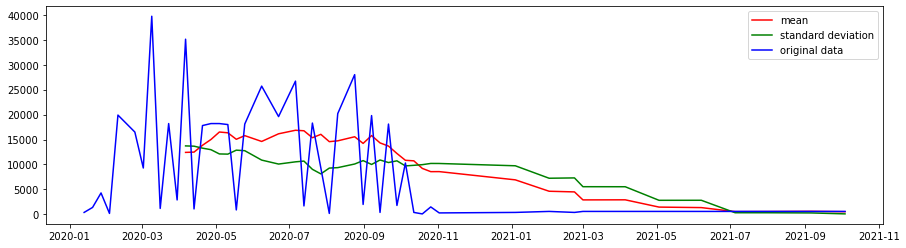

In [13]:
mean,std=rolling(data)
plot_rolling(data,mean,std)

In [14]:
def stationary_test(data):
    result=adfuller(data)
    print(result[1])
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        res='stationary'
        return res
        #print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        res='non-stationary'
        return res
        #print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
#stationary_test

In [16]:
stationary_test(data)

0.30167309600275494
ADF Test Statistic : -1.9660085322400667
p-value : 0.30167309600275494
#Lags Used : 2
Number of Observations Used : 46


'non-stationary'

### Transform data to make it stationary

In [17]:
def log(data):
    log_data=np.log(log_data)
    return log_data

In [18]:
log_data=np.log(data)
stationary_test(log_data)

0.8248984980697573
ADF Test Statistic : -0.7800974639658383
p-value : 0.8248984980697573
#Lags Used : 4
Number of Observations Used : 44


'non-stationary'

In [19]:
def diff_data(data):
    log_diff=log_data-log_data.shift(1)
    return log_diff

In [21]:
log_diff=diff_data(log_data)
stationary_test(log_diff[1:])

1.9860170519098638e-07
ADF Test Statistic : -5.966110135893695
p-value : 1.9860170519098638e-07
#Lags Used : 3
Number of Observations Used : 44


'stationary'

In [42]:
train=log_data[:30]
test=log_data[30:]

### Build Models

In [43]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(log_data, start_p=0, start_q=0,
                           max_p=5, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=214.644, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=191.863, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=185.912, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=212.645, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=184.165, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=186.020, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=186.060, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=184.191, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=185.928, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=186.353, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=182.273, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=184.226, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=189.863, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=184.096, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=184.1

In [44]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [45]:
future_forecast = stepwise_model.predict(n_periods=19)

<AxesSubplot:xlabel='RDD YW'>

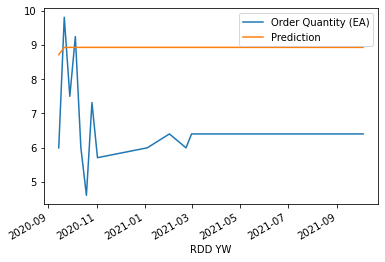

In [46]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot()

In [84]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(log_data,order=(2,1,0))
model_fit=model.fit()

In [85]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARIMA Model Results                               
=================================================================================
Dep. Variable:     D.Order Quantity (EA)   No. Observations:                   48
Model:                    ARIMA(2, 1, 0)   Log Likelihood                 -88.964
Method:                          css-mle   S.D. of innovations              1.531
Date:                   Mon, 05 Apr 2021   AIC                            185.928
Time:                           20:41:51   BIC                            193.413
Sample:                                1   HQIC                           188.756
                                                                                 
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.0105      0.099     -0.106      0.915      -0.204       0.183
ar.L1.D.Order Quantity (EA)    -0.8864      0.133     -6.686      0.000      -1.146      -0.627
ar.L2.D.Order Quantity (EA)    -0.3888      0.131     -2.964      0.003      -0.646      -0.132
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1400           -1.1281j            1.6038           -0.3758
AR.2           -1.1400           +1.1281j            1.6038            0.3758
-----------------------------------------------------------------------------
"""

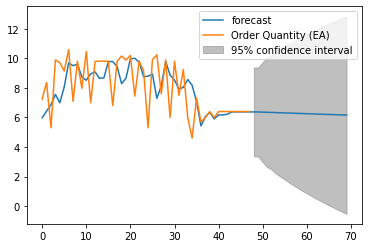

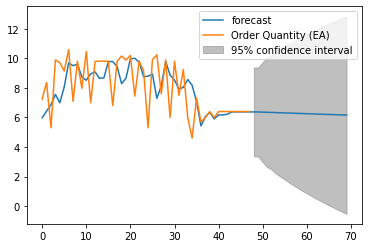

In [87]:
model_fit.plot_predict(1,70)